In [1]:
require(data.table)
require(dplyr)
require(tidyverse)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: data.table

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   4.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::l

In [38]:
#load tracker for reads
track=fread("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/Seqnums_16S.csv")
#load sample metadata
samdt=fread("/home/caroline_desouza_uml_edu/2_randomized_immune_metagenomics_PCR.csv", header=TRUE)
#load csv files after removing chimeras
asv_all=fread("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_ASV_nochim.csv")
taxa=read.csv(file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_taxa.csv", header=TRUE, row.names=1)

In [39]:
#cleaning samdt
samdt <- samdt[samdt$Date_16S != 'NA', ]
# Create a new data frame with the species, date, and transect columns
# Example samdt (make sure your data is a data.table)
setDT(samdt)
# Split Tubelabel_species by "_" and assign new columns
samdt[, c("date", "transect", "species") := {
  parts <- strsplit(Tubelabel_species, "_")
  list(
    sapply(parts, `[`, 1),  # date is first element
    sapply(parts, `[`, 4),  # transect is 4th element
    sapply(parts, `[`, 6)   # species is 6th element
  )
}]
clean_samdt <- samdt[, c("V1", "Date_Extracted", "Raw_ng_ul", "Extraction_physical_location", "Date_Enriched", "Date_ITS2", "Microbe_Location") := NULL]
head(samdt)

Tubelabel_species,Health_Status,colony,Date_16S,16S double band,date,transect,species
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
052022_BEL_CBC_T1_2_SSID,Healthy,1_3,1_22_2025,,052022,T1,SSID
092023_BEL_CBC_T1_175_PAST,Healthy,1_13,1_22_2025,y,092023,T1,PAST
022024_BEL_CBC_T3_851_PSTR,Healthy,3_70,1_23_2025,,022024,T3,PSTR
082024_BEL_CBC_T4_1609_OFAV,Healthy,4_78,1_23_2025,y,082024,T4,OFAV
122023_BEL_CBC_T3_526_SSID,Healthy,3_5,1_23_2025,,122023,T3,SSID
112023_BEL_CBC_T4_399_MCAV,Healthy,4_76,1_23_2025,,112023,T4,MCAV


In [40]:
#cleaning track of samples with less than 10K reads
clean_track <- track[track$nonchim > 10000, ]
head(clean_track)

V1,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
012024-BEL-CBC-T1-557-SSID,189570,176082,171436,173162,142705,129120
012024-BEL-CBC-T1-563-PSTR,98511,89332,88739,88868,87695,44586
012024-BEL-CBC-T2-601-OFAV,280308,263766,262084,262620,250901,173382
012024-BEL-CBC-T3-631-MCAV,536790,497421,495886,496193,481028,404924
012024-BEL-CBC-T3-633-MCAV,163169,154836,154032,153929,151918,62656
012024-BEL-CBC-T3-637-SSID,22749,21151,20332,20453,19464,17819


In [41]:
setnames(clean_track, c("V1"), c("Tubelabel_species"), skip_absent=TRUE)
head(clean_track)

Tubelabel_species,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
012024-BEL-CBC-T1-557-SSID,189570,176082,171436,173162,142705,129120
012024-BEL-CBC-T1-563-PSTR,98511,89332,88739,88868,87695,44586
012024-BEL-CBC-T2-601-OFAV,280308,263766,262084,262620,250901,173382
012024-BEL-CBC-T3-631-MCAV,536790,497421,495886,496193,481028,404924
012024-BEL-CBC-T3-633-MCAV,163169,154836,154032,153929,151918,62656
012024-BEL-CBC-T3-637-SSID,22749,21151,20332,20453,19464,17819


In [42]:
#reconfigure names in asv_all
setDT(asv_all, keep.rownames = "Tubelabel_species")[]

V1,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,TACGGGGGATGCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGGAGCGAATGGG,ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,⋯,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATAGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCAAACAGGATTAGAAACCCGTGTAGTCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGAC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATAGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCAAACAGGATTAGATACCCTCGTAGTCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGAC,GCACGTAGGCGGCGCGGTAAGTCCATTGTGAAAGCCCTCGGCTCAACCGAGGAAGTGCAGTGGAAACTGCCGTGCTTGAGTACGGGAGAGGAGAGTGGAATTCCCGGTGAAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAAGCGGCTCTCTGGACCGTCACTGACGCTGAGGTGCGAAAGCTGGGGGAGCGAACGGGATTAGATACCCTAGTAGTCCCTGTCTCTTATACACATCTCC,GGGTGTCAGCAGCCGCGGTAATACGGAGGGTCCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTAGATCAGTCGGGTGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTCGATACTGTCTGACTGGAGTATGGGAGAGGGCAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAACACCTGTGGCGAAGGCGGCTGCCTGGCCCAATACTGACGCTGAGGTG,ATACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGCTGACCAAGTCAGAGGTGAAAGGCCCGGGCTCAACCTGGGAACTGCCTTTGAAACTGGTCGGCTCGAGTCCGGAAGAGGATAGCGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTATCTGGTCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACTGCTGTGATCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGG

In [44]:
setnames(asv_all, c("V1"), c("Tubelabel_species"), skip_absent=TRUE)

In [45]:
#great now inner join to format asv_all based on clean_track
# Ensure both are data.tables
setDT(asv_all)
setDT(clean_track)
head(asv_all)
asv_clean <- merge(asv_all, clean_track, by = "Tubelabel_species", all = FALSE)

Tubelabel_species,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,TACGGGGGATGCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGGAGCGAATGGG,ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,⋯,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATAGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCAAACAGGATTAGAAACCCGTGTAGTCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGAC,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATAGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCAAACAGGATTAGATACCCTCGTAGTCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGAC,GCACGTAGGCGGCGCGGTAAGTCCATTGTGAAAGCCCTCGGCTCAACCGAGGAAGTGCAGTGGAAACTGCCGTGCTTGAGTACGGGAGAGGAGAGTGGAATTCCCGGTGAAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAAGCGGCTCTCTGGACCGTCACTGACGCTGAGGTGCGAAAGCTGGGGGAGCGAACGGGATTAGATACCCTAGTAGTCCCTGTCTCTTATACACATCTCC,GGGTGTCAGCAGCCGCGGTAATACGGAGGGTCCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTAGATCAGTCGGGTGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATTCGATACTGTCTGACTGGAGTATGGGAGAGGGCAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGATATGTGGAGGAACACCTGTGGCGAAGGCGGCTGCCTGGCCCAATACTGACGCTGAGGTG,ATACGGAGGGGGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGCGTAGGCGGCTGACCAAGTCAGAGGTGAAAGGCCCGGGCTCAACCTGGGAACTGCCTTTGAAACTGGTCGGCTCGAGTCCGGAAGAGGATAGCGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCAGTGGCGAAGGCGGCTATCTGGTCCGGTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACAGG,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACTGCTGTGATCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGG

In [46]:
#check to make sure clean_track matches asv_clean
nrow(asv_all)
nrow(asv_clean)
nrow(clean_track)

[1] 97

[1] 58

[1] 58

In [47]:
# Step 1: Replace '-' with '_' in asv_clean$Tube
asv_clean$Tubelabel_species <- gsub("-", "_", asv_clean$Tubelabel_species)
head(asv_clean)

Tubelabel_species,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,TACGGGGGATGCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGGAGCGAATGGG,ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,580,0,4781,0,60,48,418,32,367,⋯,0,0,0,0,189570,176082,171436,173162,142705,129120
012024_BEL_CBC_T1_563_PSTR,0,0,0,8,0,0,0,0,0,⋯,0,0,0,0,98511,89332,88739,88868,87695,44586
012024_BEL_CBC_T2_601_OFAV,279,6,2321,0,119,

In [52]:
#exclude samples that are not in asv_clean
samdf <- merge(samdt, asv_clean, by = "Tubelabel_species", all = FALSE)

In [53]:
class(asv_clean)
class(samdf)
class(taxa)

[1] "data.table" "data.frame"

[1] "data.table" "data.frame"

[1] "data.frame"

In [54]:

#troubleshoot this step
#fix asv_all rownames
rows=as.vector(asv_clean[,1])
asv_clean=asv_clean[,-1]
asv_clean=apply(asv_clean, 2, as.numeric)
row.names(asv_clean)=rows$Tubelabel_species

head(asv_clean)

,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,TACGGGGGATGCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGGAGCGAATGGG,ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,TACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCGAACGGG,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim
012024_BEL_CBC_T1_557_SSID,580,0,4781,0,60,48,418,32,367,0,⋯,0,0,0,0,189570,176082,171436,173162,142705,129120
012024_BEL_CBC_T1_

switching gears to making sure samdf, asv_clean, and taxa are all in proper order for phyloseq

In [55]:
#optional to set rownames
samdf <- as.data.frame(samdf)              # Convert to data.frame (from data.table)
rownames(samdf) <- samdf$Tubelabel_species # Set rownames
samdf$Tubelabel_species <- NULL    
head(samdf)

,Health_Status,colony,Date_16S,16S double band,date,transect,species,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,580,0,4781,⋯,0,0,0,0,189570,176082,171436,173162,142705,129120
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,0,0,0,⋯,0,0,0,0,98511,89332,88739,88868,87695,44586
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,279,6,2321,⋯,0,0,0,0,280308,263766,262084,262620,250901,173382
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,328,0,117,⋯,0,0,0,0,536790,497421,495886,496193,481028,404924
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,0,0,0,⋯,0,0,0,0,163169,154836,154032,153929,151918,62656
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,0,128,0,⋯,0,0,0,0,22749,21151,20332,20453,19464,17819


In [56]:
head(asv_clean)
head(samdf)

,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,TACGGGGGATGCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGGAGCGAATGGG,ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,TACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCGAACGGG,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim
012024_BEL_CBC_T1_557_SSID,580,0,4781,0,60,48,418,32,367,0,⋯,0,0,0,0,189570,176082,171436,173162,142705,129120
012024_BEL_CBC_T1_

,Health_Status,colony,Date_16S,16S double band,date,transect,species,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,580,0,4781,⋯,0,0,0,0,189570,176082,171436,173162,142705,129120
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,0,0,0,⋯,0,0,0,0,98511,89332,88739,88868,87695,44586
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,279,6,2321,⋯,0,0,0,0,280308,263766,262084,262620,250901,173382
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,328,0,117,⋯,0,0,0,0,536790,497421,495886,496193,481028,404924
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,0,0,0,⋯,0,0,0,0,163169,154836,154032,153929,151918,62656
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,0,128,0,⋯,0,0,0,0,22749,21151,20332,20453,19464,17819


In [57]:
#make sure rownames are in same order
common_samples <- intersect(rownames(samdf), rownames(asv_clean))

# Reorder both objects to match the same order
samdf <- samdf[common_samples, , drop = FALSE]
asv_clean <- asv_clean[common_samples, , drop = FALSE]

In [58]:
#double check that all rownames match
all(rownames(asv_clean) %in% rownames(samdf))  # Should be TRUE
all(rownames(samdf) %in% rownames(asv_clean))  # Should be TRUE

[1] TRUE

[1] TRUE

In [59]:
# Reorder taxa to match asv_all
#Get common ASVs
common_asvs <- intersect(colnames(asv_clean), rownames(taxa))

# Subset both
asv_clean <- asv_clean[, common_asvs]
taxa <- taxa[common_asvs, ]

In [60]:
sum(is.na(match(colnames(asv_clean), rownames(taxa))))
identical(colnames(asv_clean), rownames(taxa))  # Should be TRUE

[1] 0

[1] TRUE

final checks for phyloseq

In [61]:
#check if asv_clean is numeric
all(sapply(as.data.table(asv_clean), is.numeric))

#check if row names and column names match
identical(colnames(asv_clean), rownames(taxa))  # MUST be TRUE
identical(rownames(asv_clean), rownames(samdf))  # MUST be TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [62]:
theme_set(theme_bw())

In [63]:
# Convert asv_all to otu_table (specify taxa_are_rows = TRUE/FALSE depending on your data)
otu <- otu_table(asv_clean, taxa_are_rows = FALSE)  # or TRUE if taxa in rows

# Sample metadata as sample_data
sampledata <- sample_data(samdf)

taxa=as.matrix(taxa)

taxa=tax_table(taxa)

# Construct phyloseq object
ps <- phyloseq(otu, sampledata, taxa)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 95300 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95313 sample variables ]
tax_table()   Taxonomy Table:    [ 95300 taxa by 6 taxonomic ranks ]

In [64]:
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [65]:
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 93551 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95313 sample variables ]
tax_table()   Taxonomy Table:    [ 93551 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 93551 reference sequences ]

In [66]:
#normalizing OTU by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
OTU = transform_sample_counts(otu, function(x) 1E6 * x / sum(x))

In [67]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(physeq) {
  sd <- sample_data(physeq)
  return(as(sd,"data.frame"))
}

# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(physeq) {
  OTU <- otu_table(physeq)
  if (taxa_are_rows(OTU)) {
    OTU <- t(OTU)
  }
  return(as(OTU, "matrix"))
}

In [68]:
#checkpoint to save phyloseq output without having to rerun this notebook
write.csv(as.data.frame(otu_table(ps)), "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/10Kotu_table.csv")

In [69]:
#remember to set.seed to make things reproducible
set.seed(100) 

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


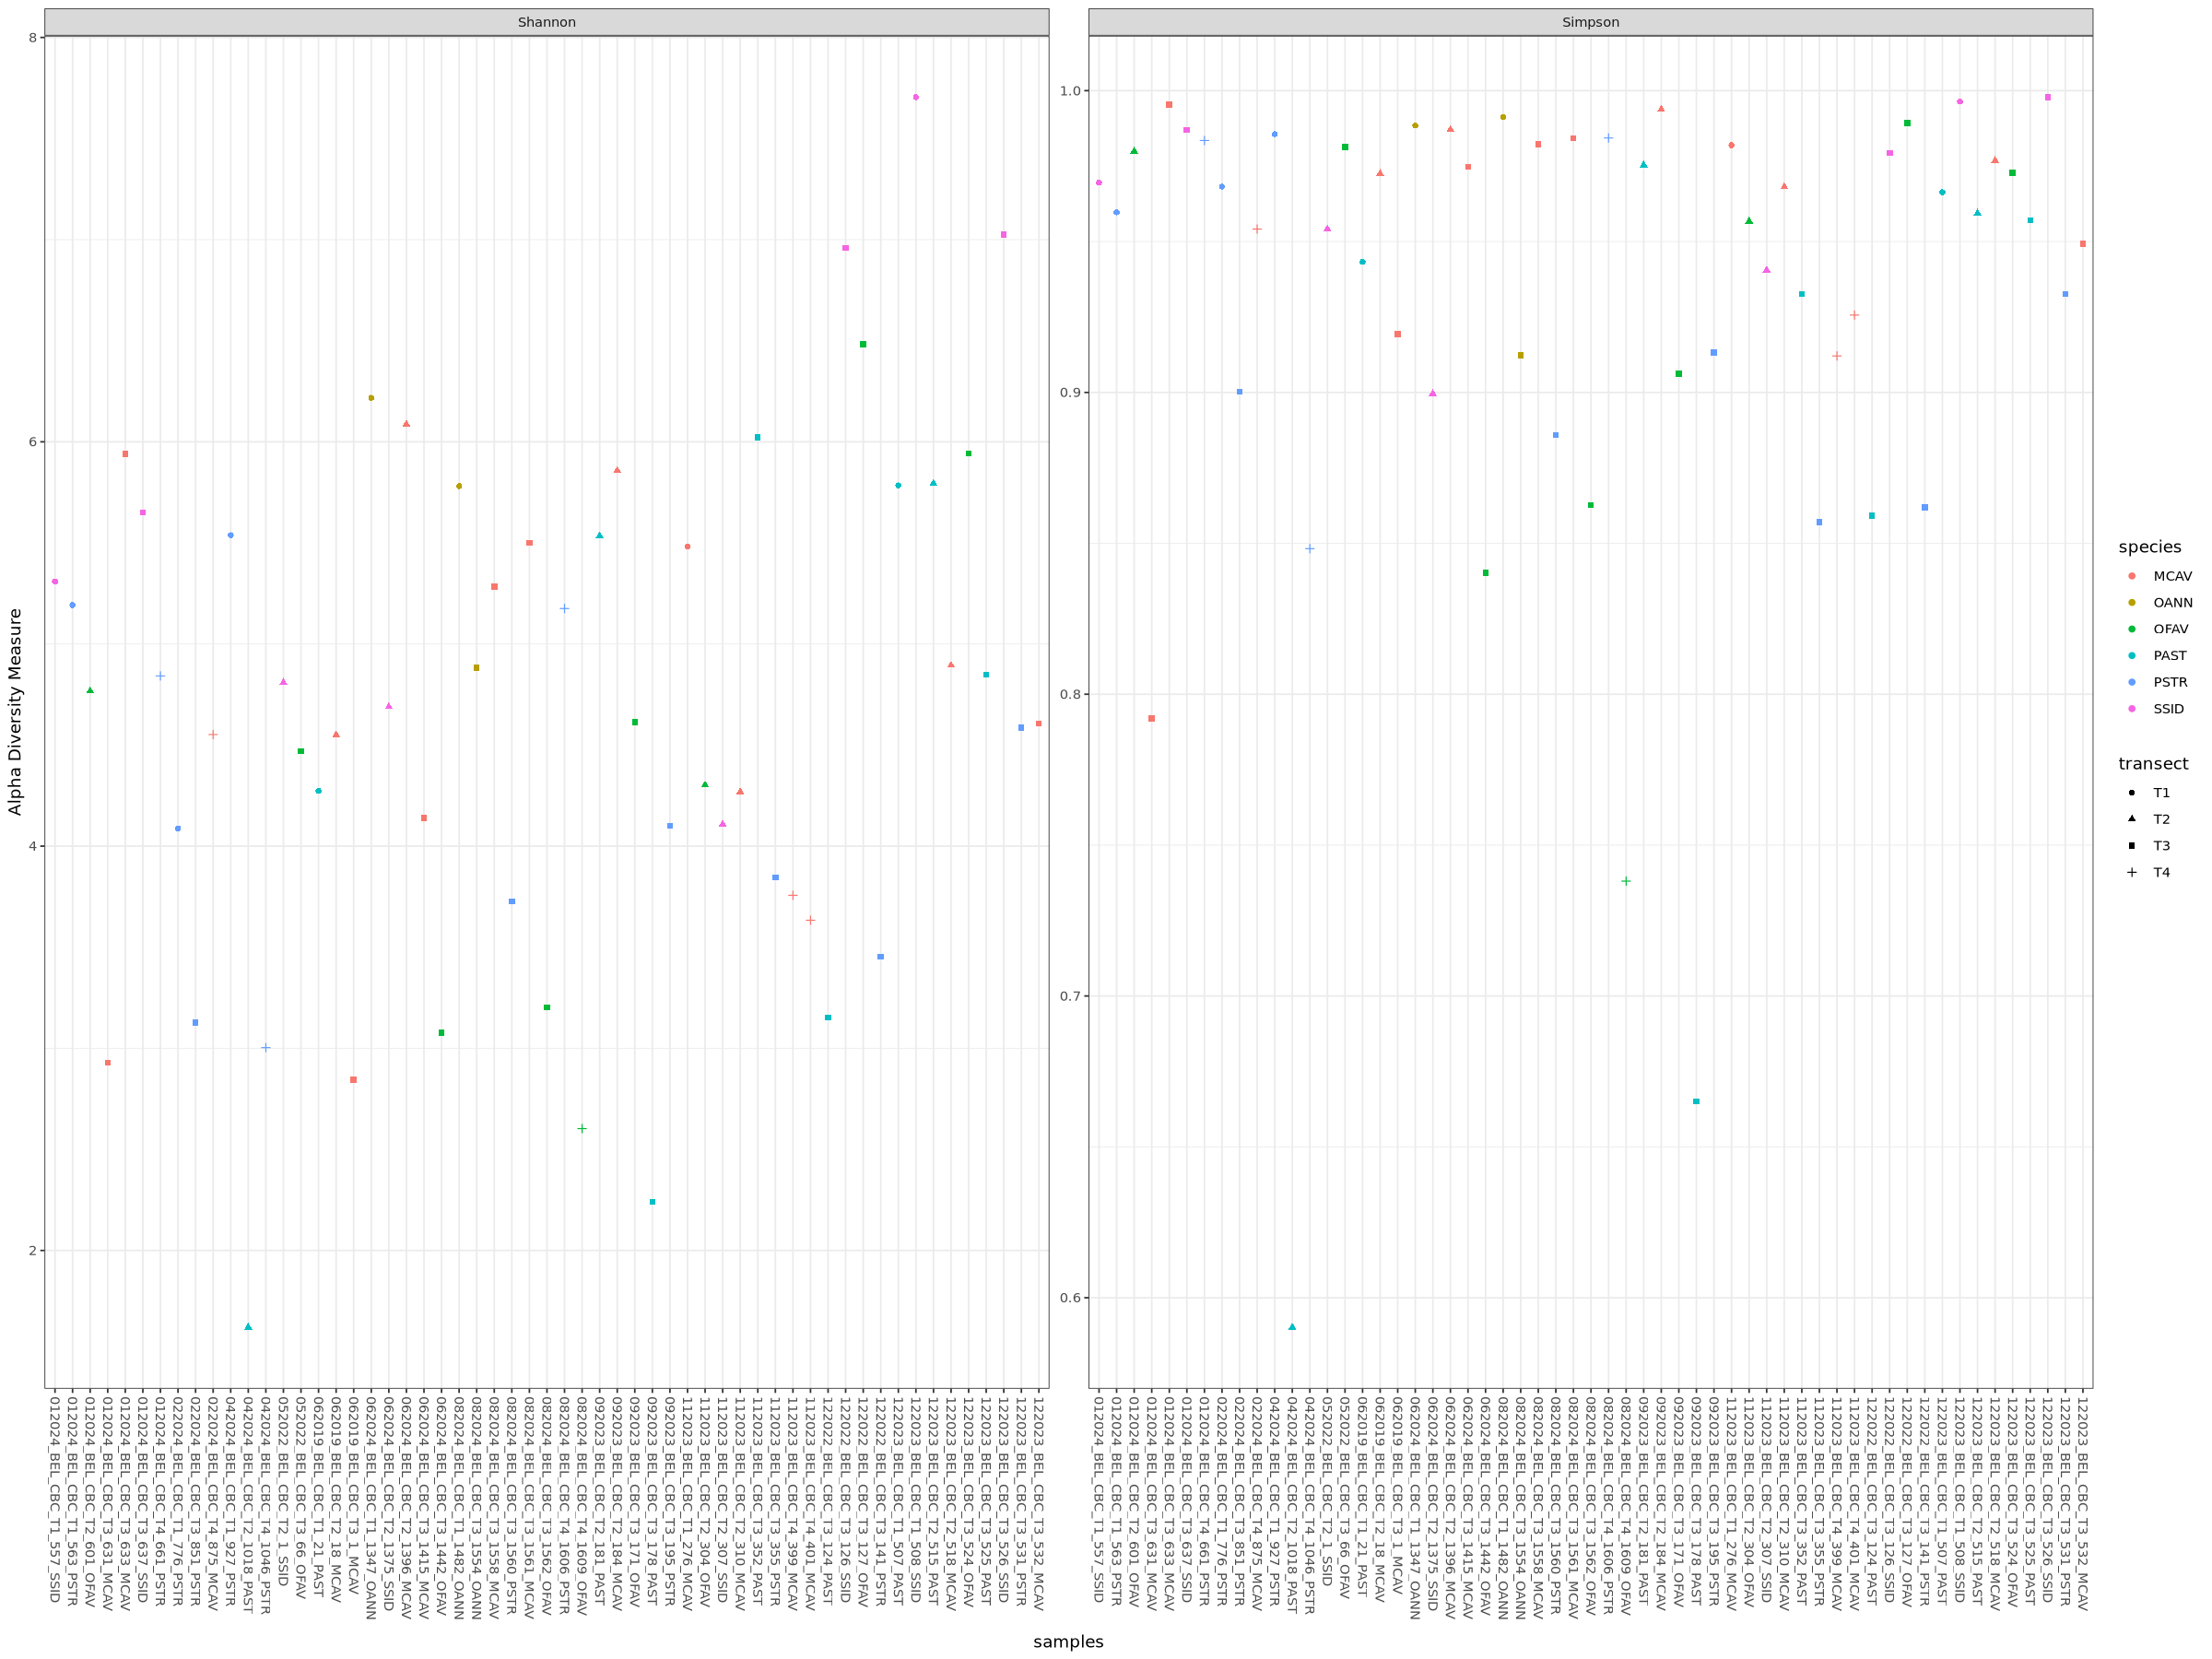

In [70]:
plot_richness(ps, measures=c("Shannon", "Simpson"), color="species", shape="transect")

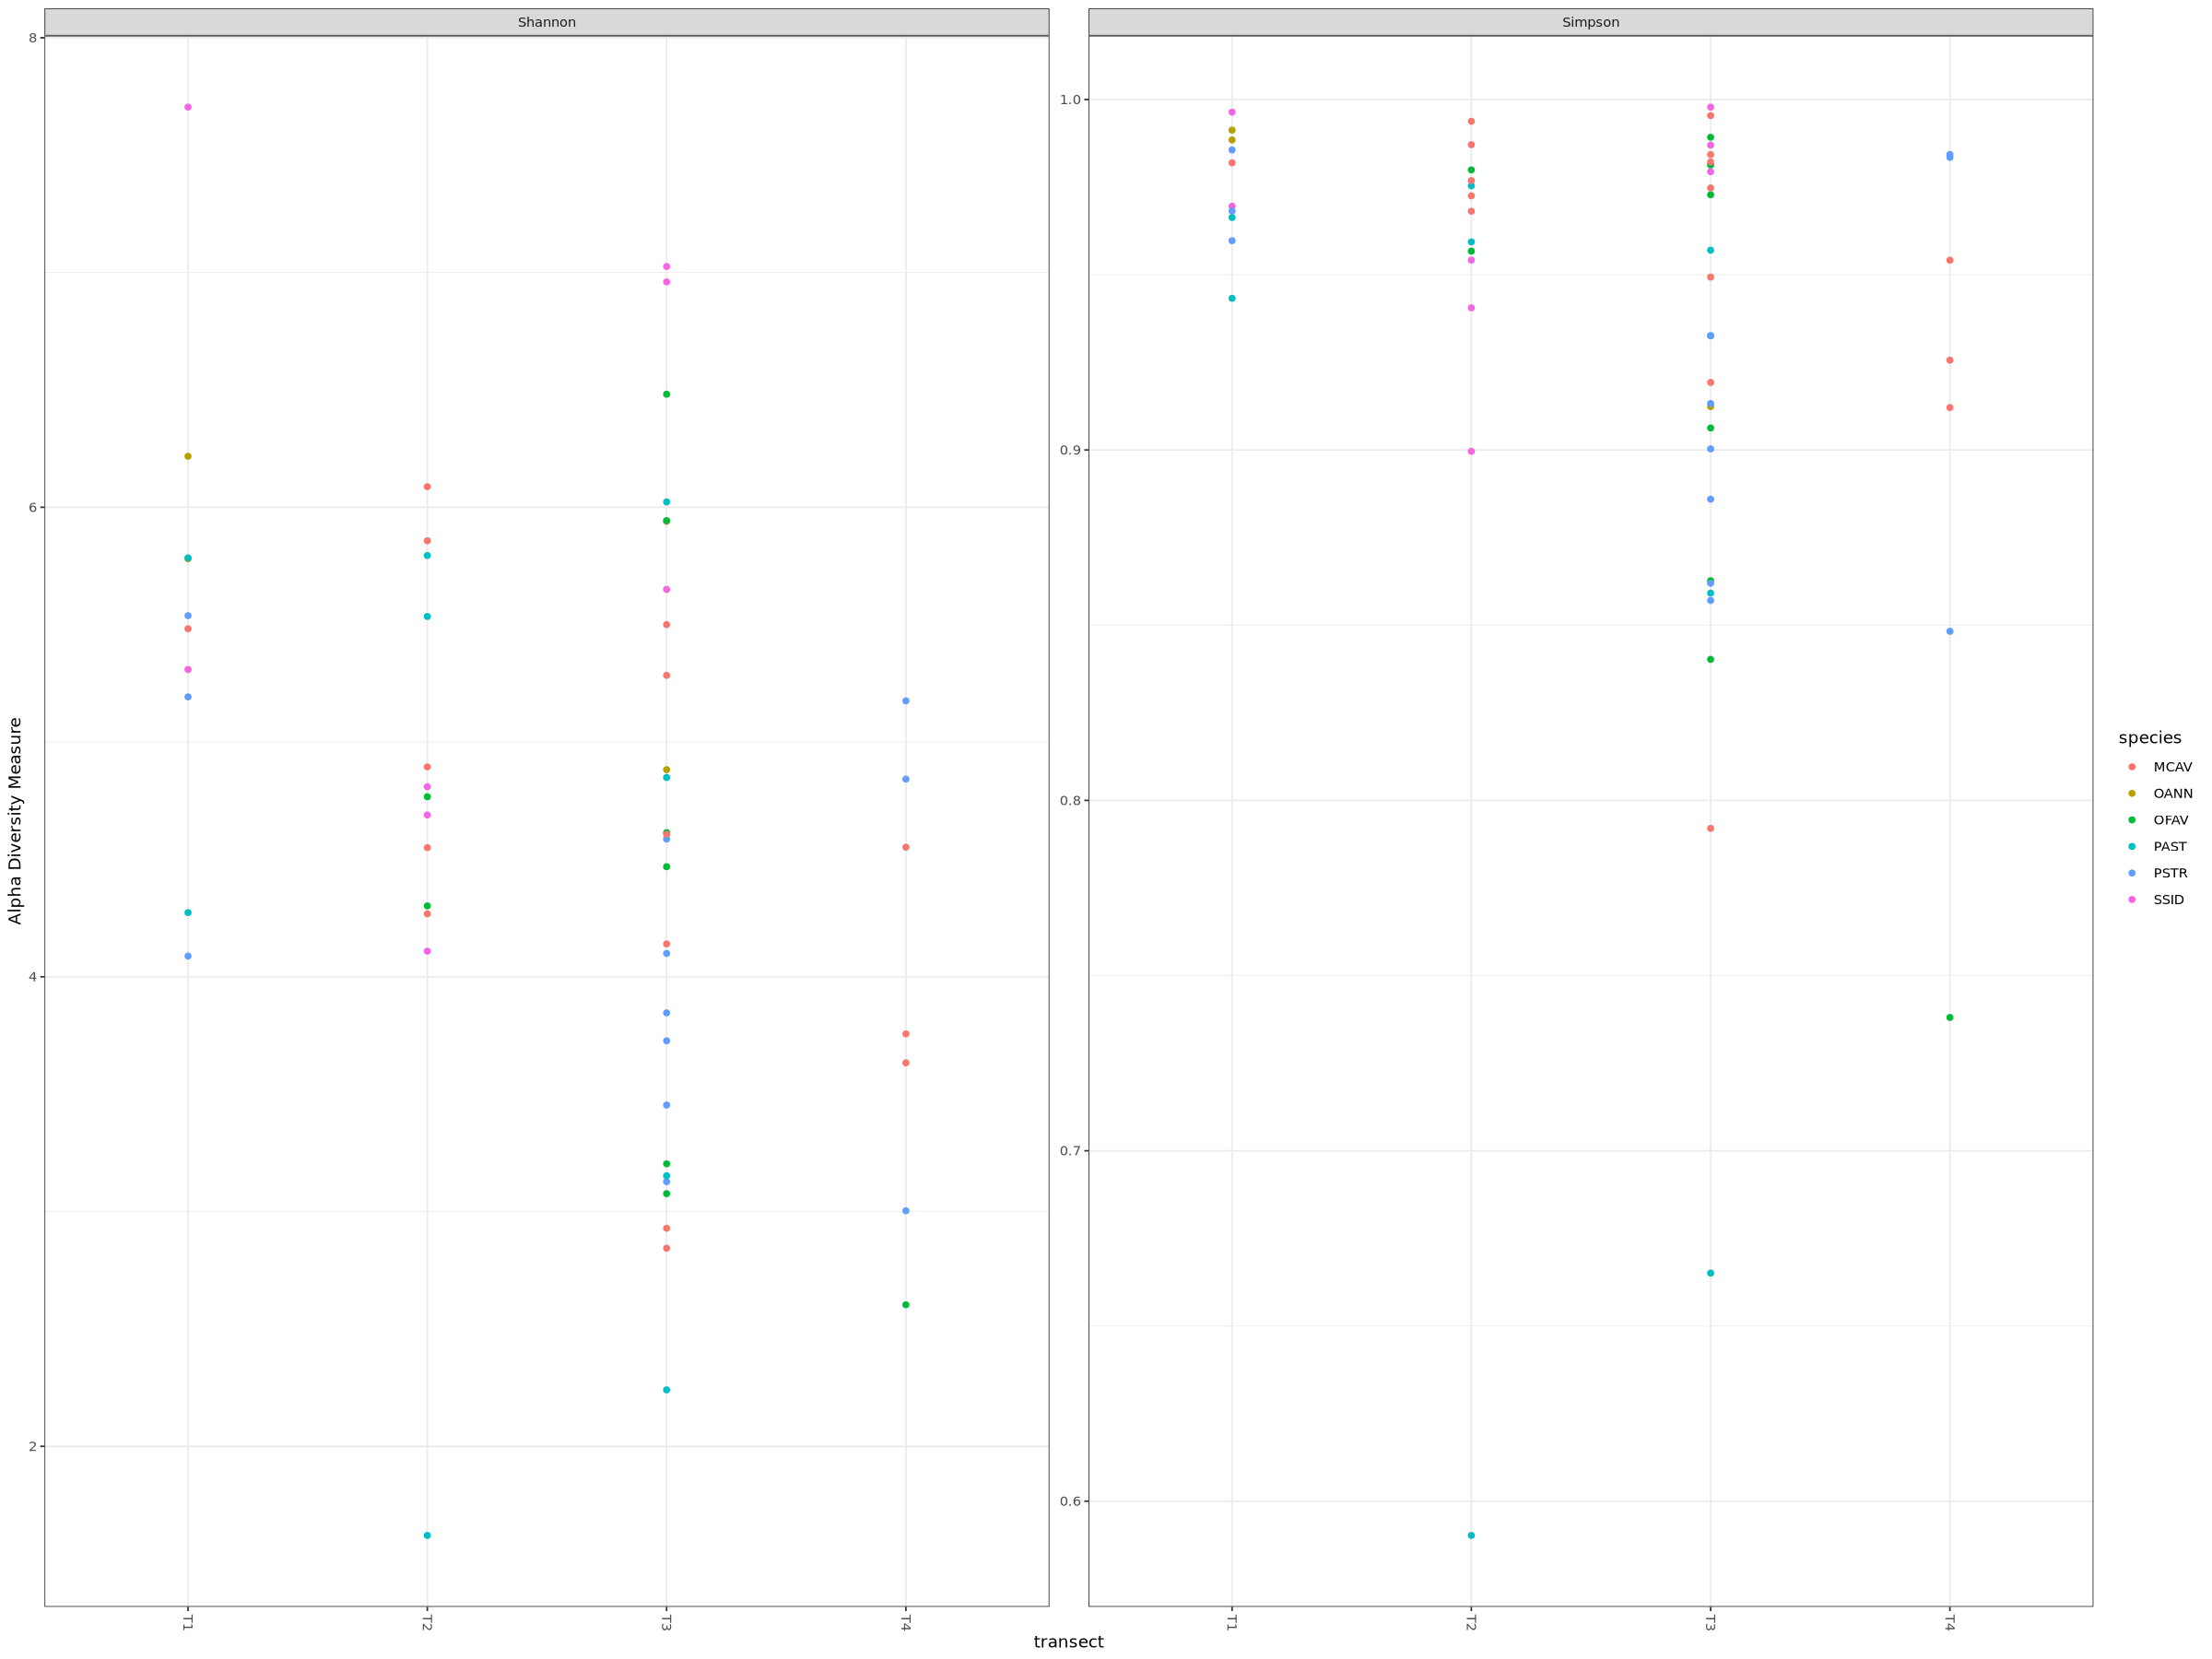

In [71]:
plot_richness(ps, x="transect", measures=c("Shannon", "Simpson"), color="species")

In [72]:
# Transform data to proportions as appropriate for Bray-Curtis distances
ps.prop <- transform_sample_counts(ps, function(otu) otu/sum(otu))
ord.nmds.bray <- ordinate(ps.prop, method="NMDS", distance="bray")

Run 0 stress 0.1336857 
Run 1 stress 0.1371962 
Run 2 stress 0.1336779 
... New best solution
... Procrustes: rmse 0.0007195203  max resid 0.003983794 
... Similar to previous best
Run 3 stress 0.1374642 
Run 4 stress 0.1333424 
... New best solution
... Procrustes: rmse 0.03074324  max resid 0.1322472 
Run 5 stress 0.1327967 
... New best solution
... Procrustes: rmse 0.02387443  max resid 0.1251729 
Run 6 stress 0.1320646 
... New best solution
... Procrustes: rmse 0.02558751  max resid 0.09078426 
Run 7 stress 0.1332301 
Run 8 stress 0.1377557 
Run 9 stress 0.1364709 
Run 10 stress 0.1349797 
Run 11 stress 0.1300295 
... New best solution
... Procrustes: rmse 0.02066686  max resid 0.1438548 
Run 12 stress 0.1326616 
Run 13 stress 0.1389456 
Run 14 stress 0.1332747 
Run 15 stress 0.1320525 
Run 16 stress 0.1367685 
Run 17 stress 0.137499 
Run 18 stress 0.1299951 
... New best solution
... Procrustes: rmse 0.02549094  max resid 0.09737361 
Run 19 stress 0.1332358 
Run 20 stress 0.1331

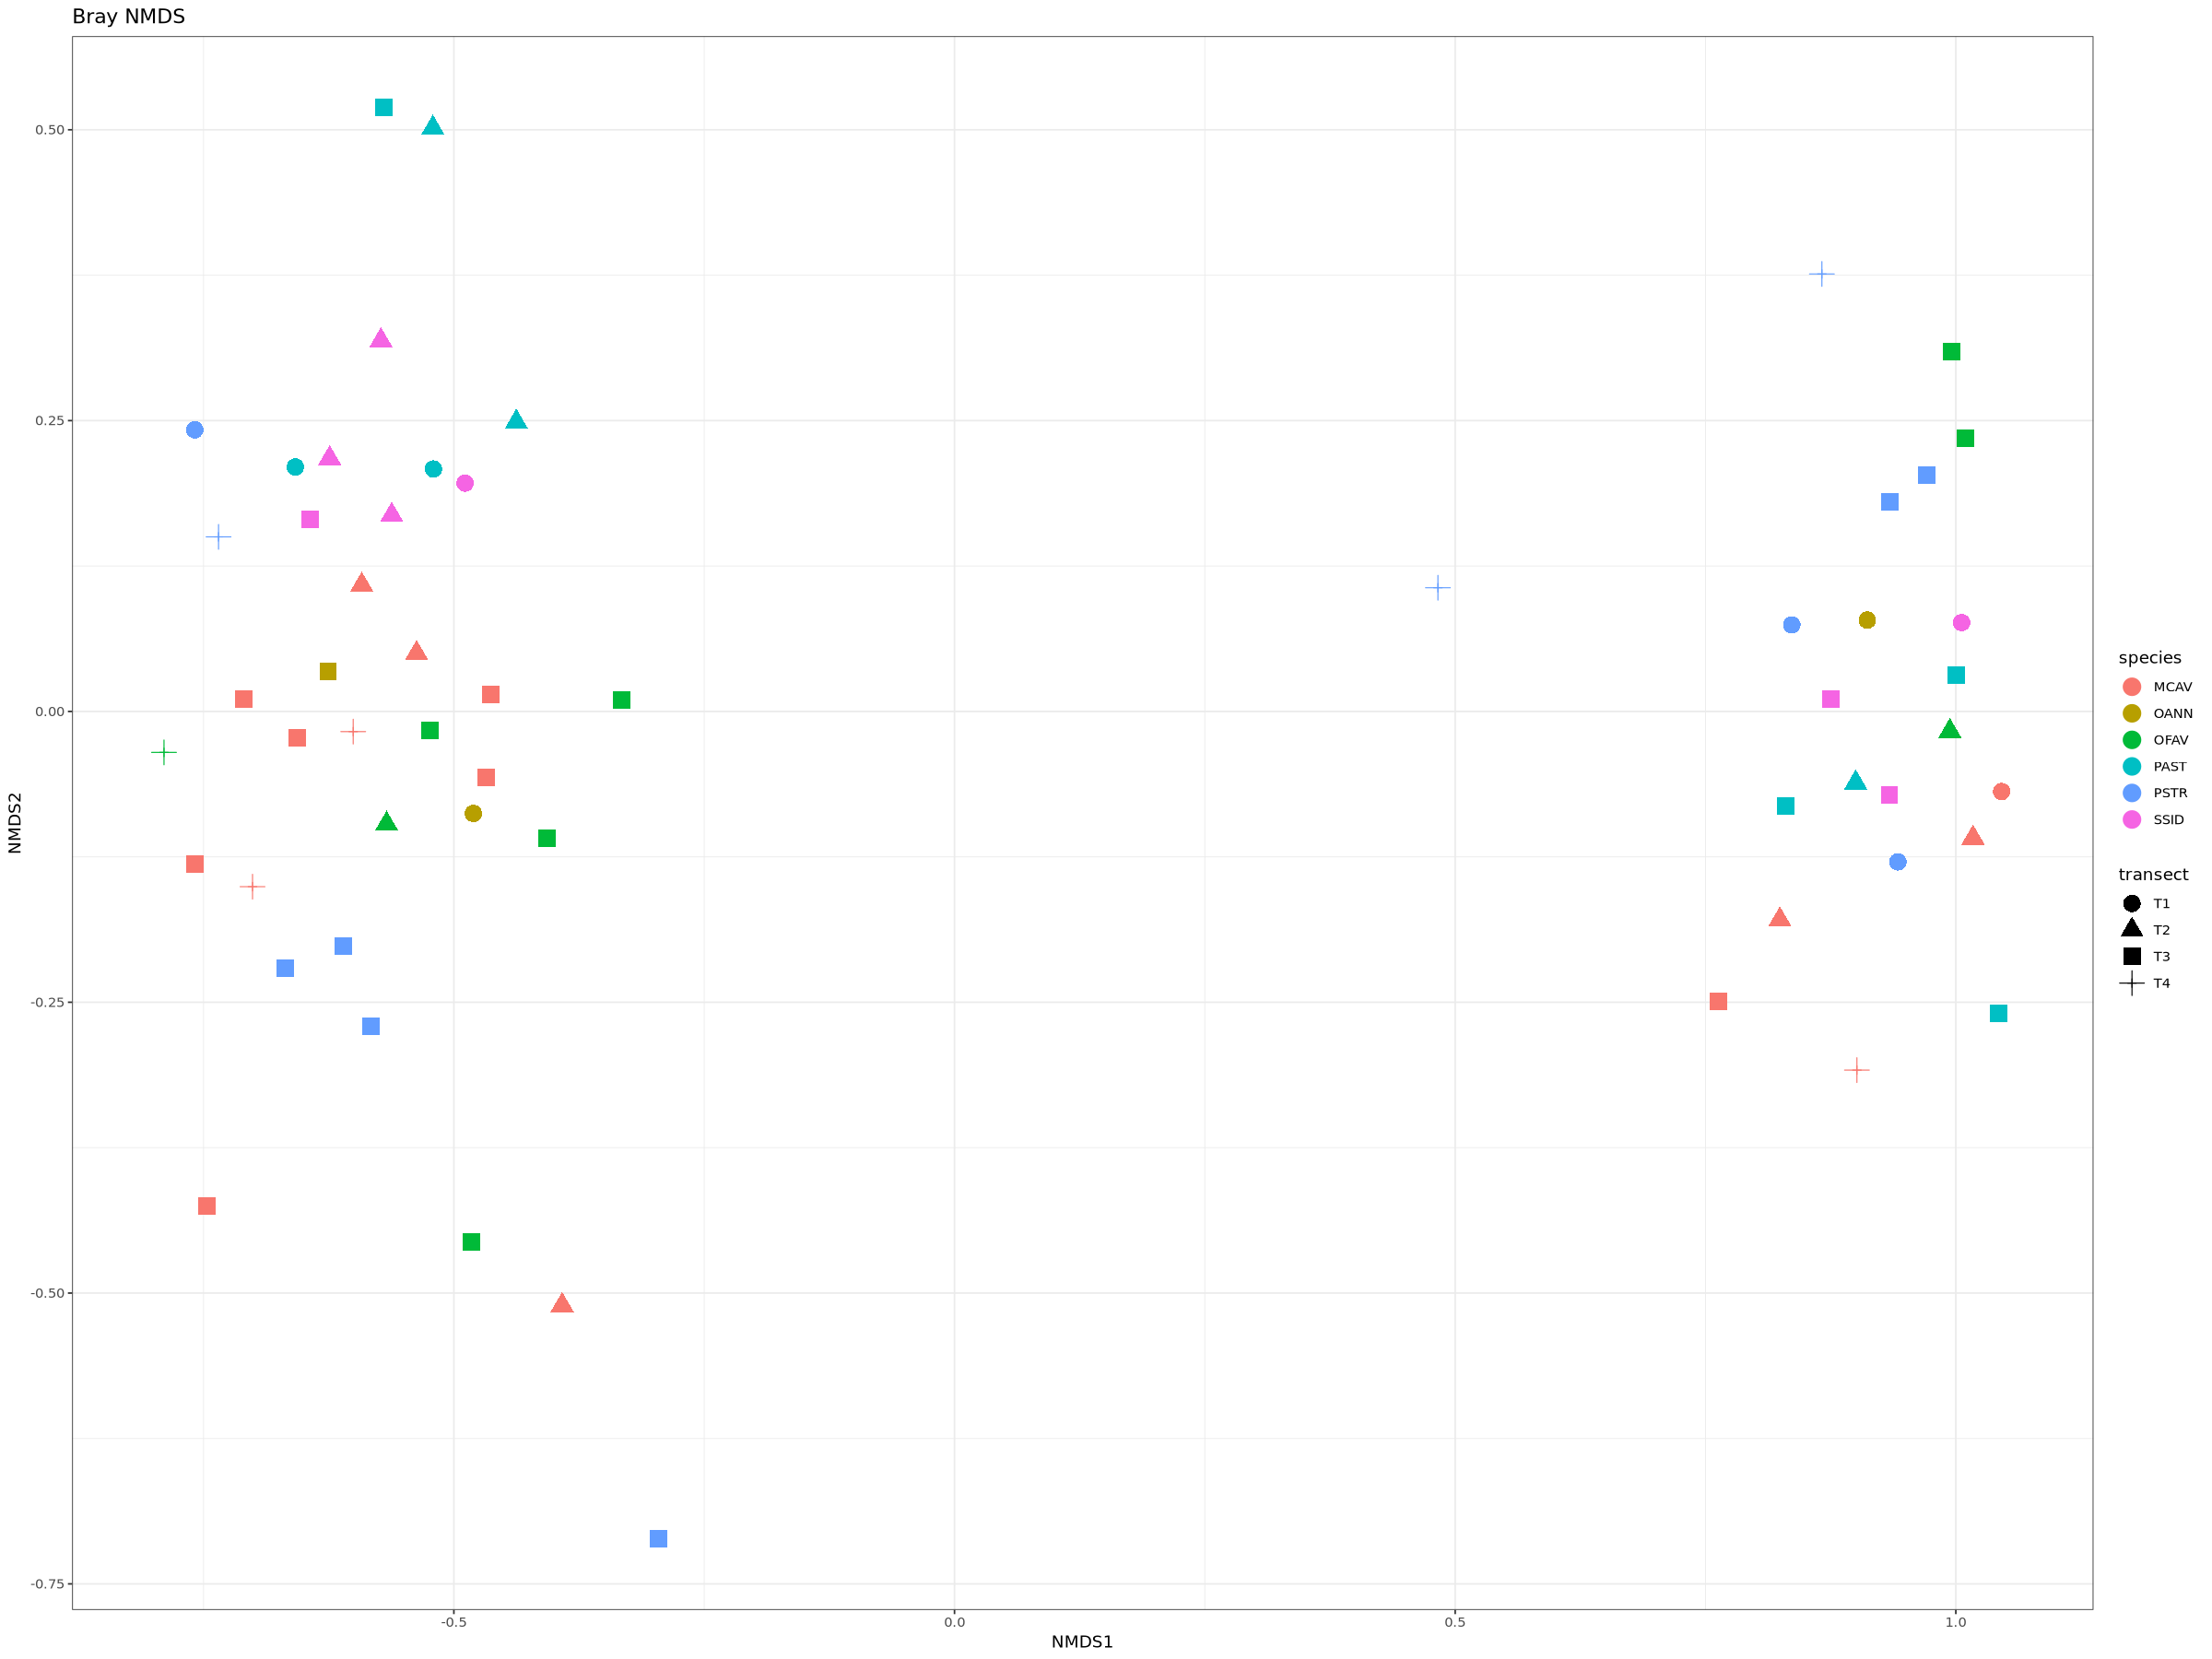

In [76]:
p=plot_ordination(ps.prop, ord.nmds.bray, color="species", shape="transect", title="Bray NMDS" )
p+ geom_point(size=5)

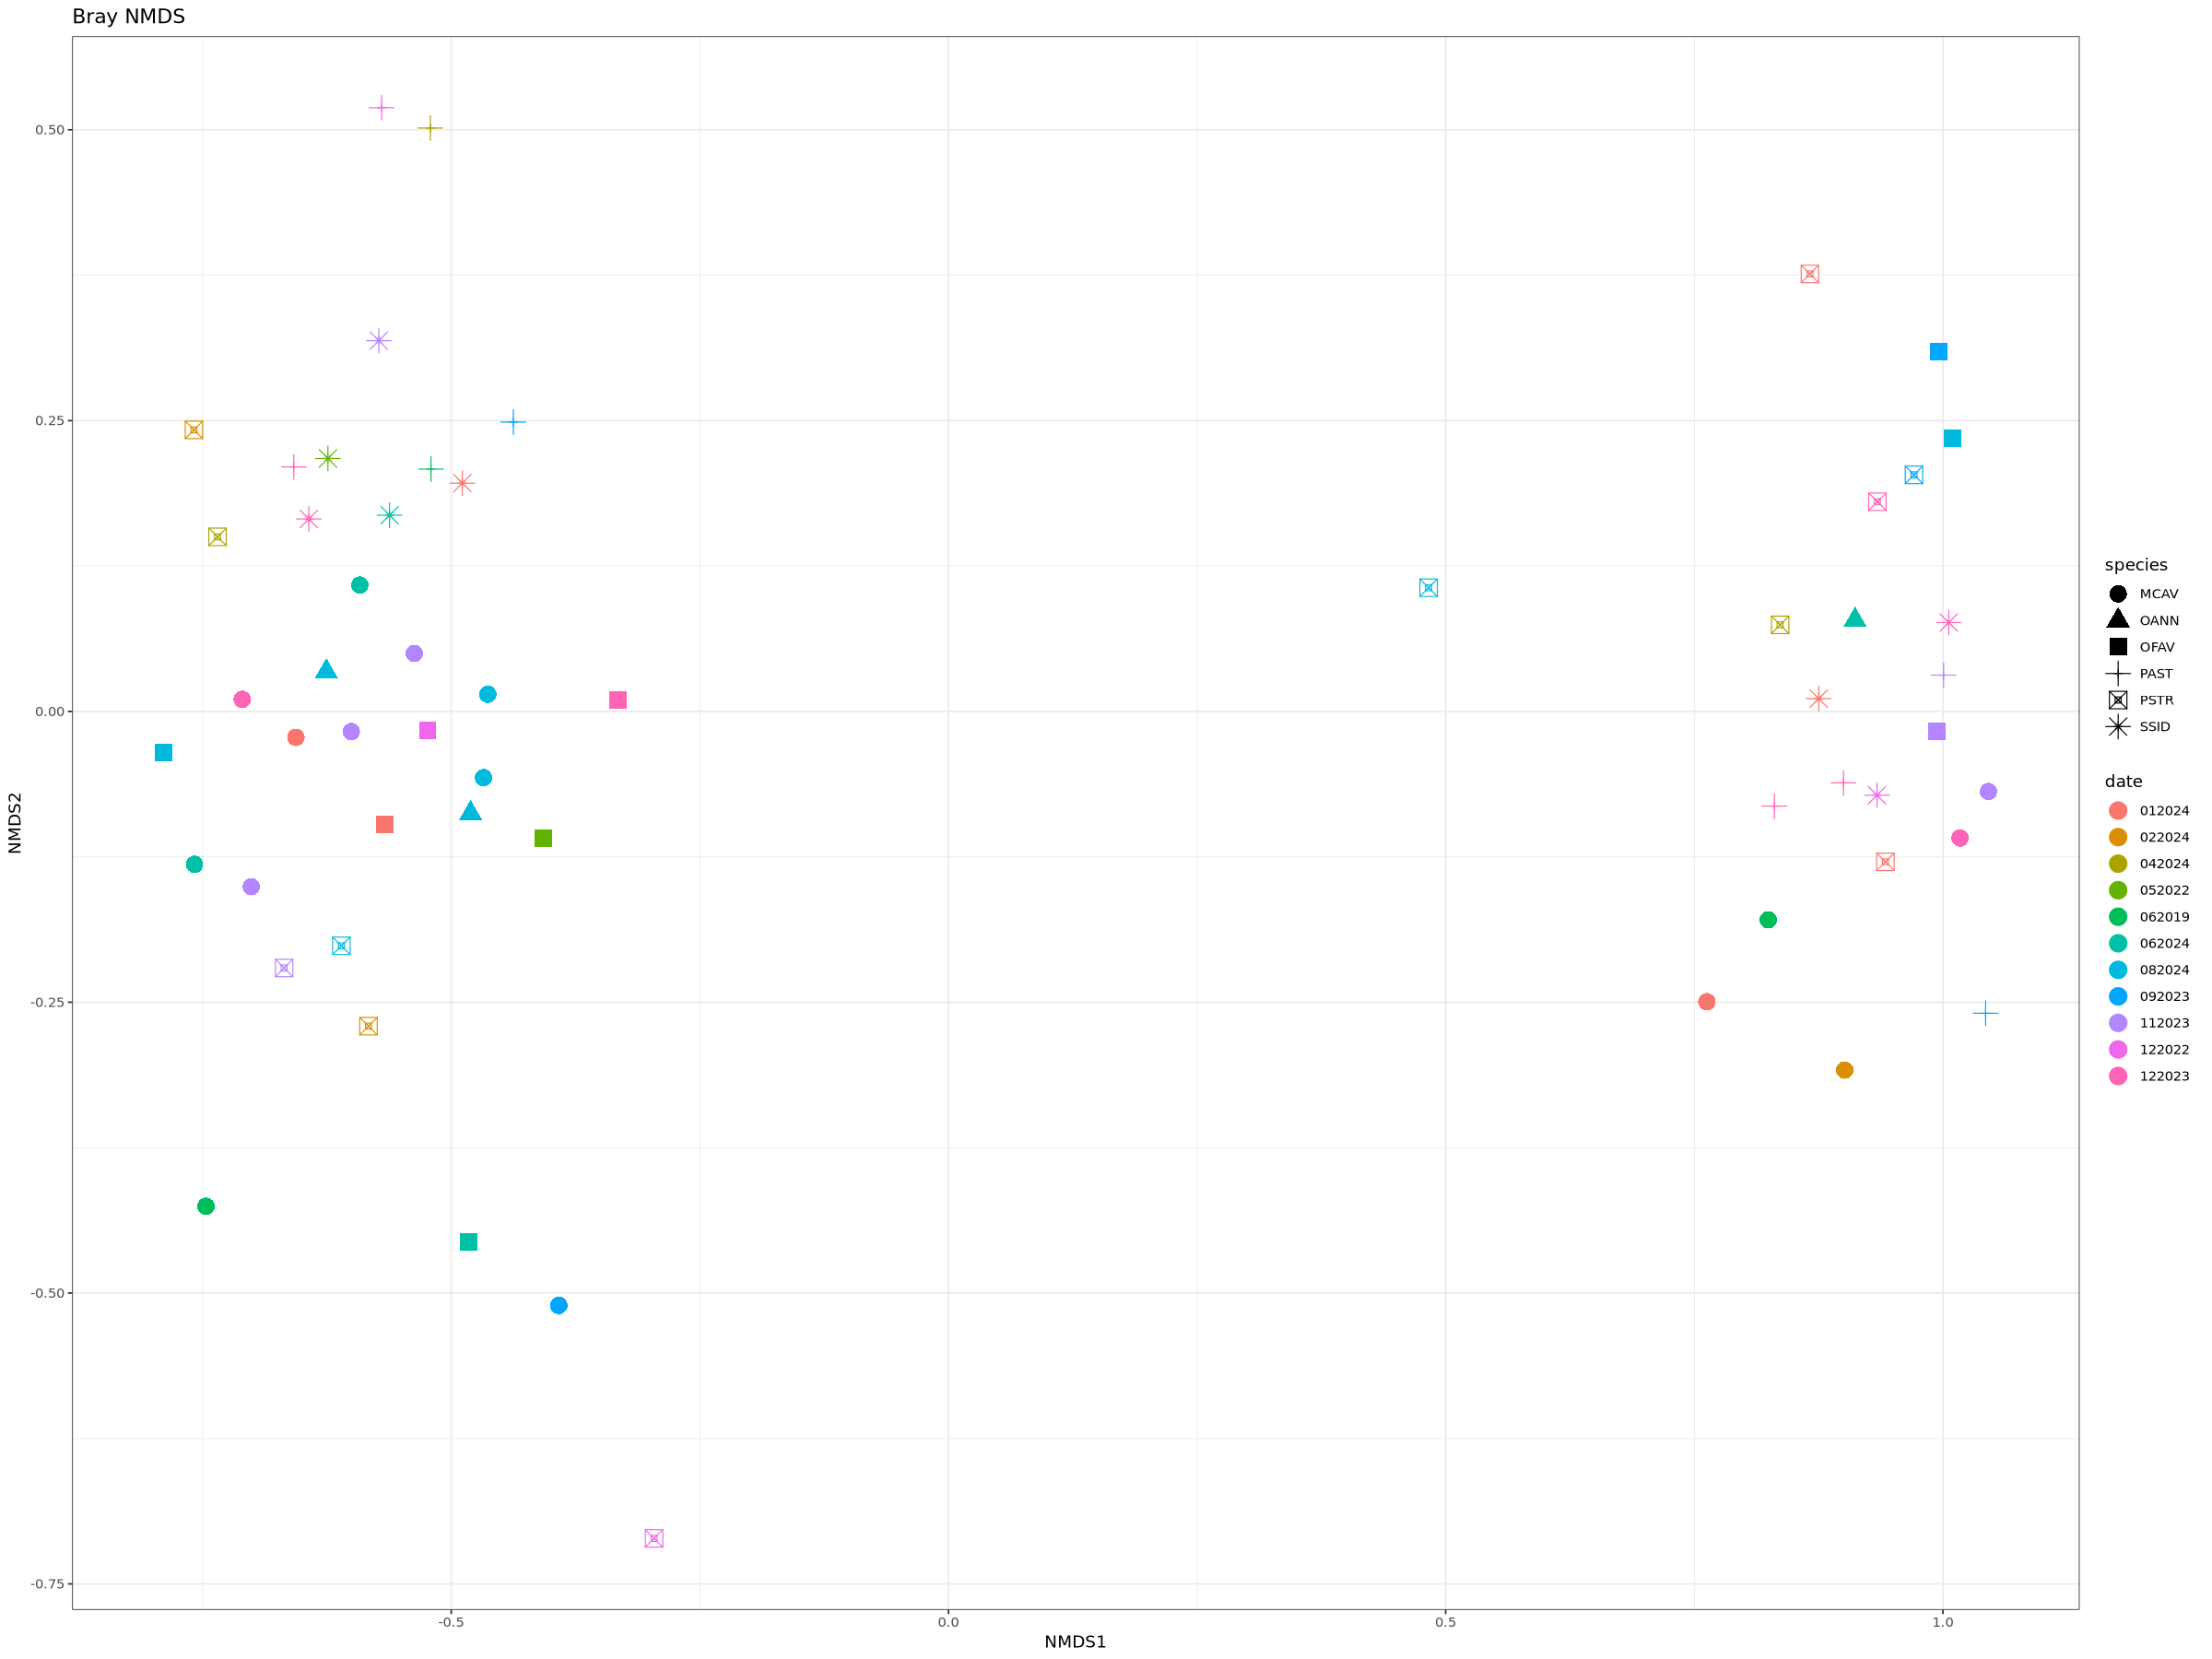

In [79]:
p=plot_ordination(ps.prop, ord.nmds.bray, color="date", shape="species" , title="Bray NMDS" )
p+ geom_point(size=5)

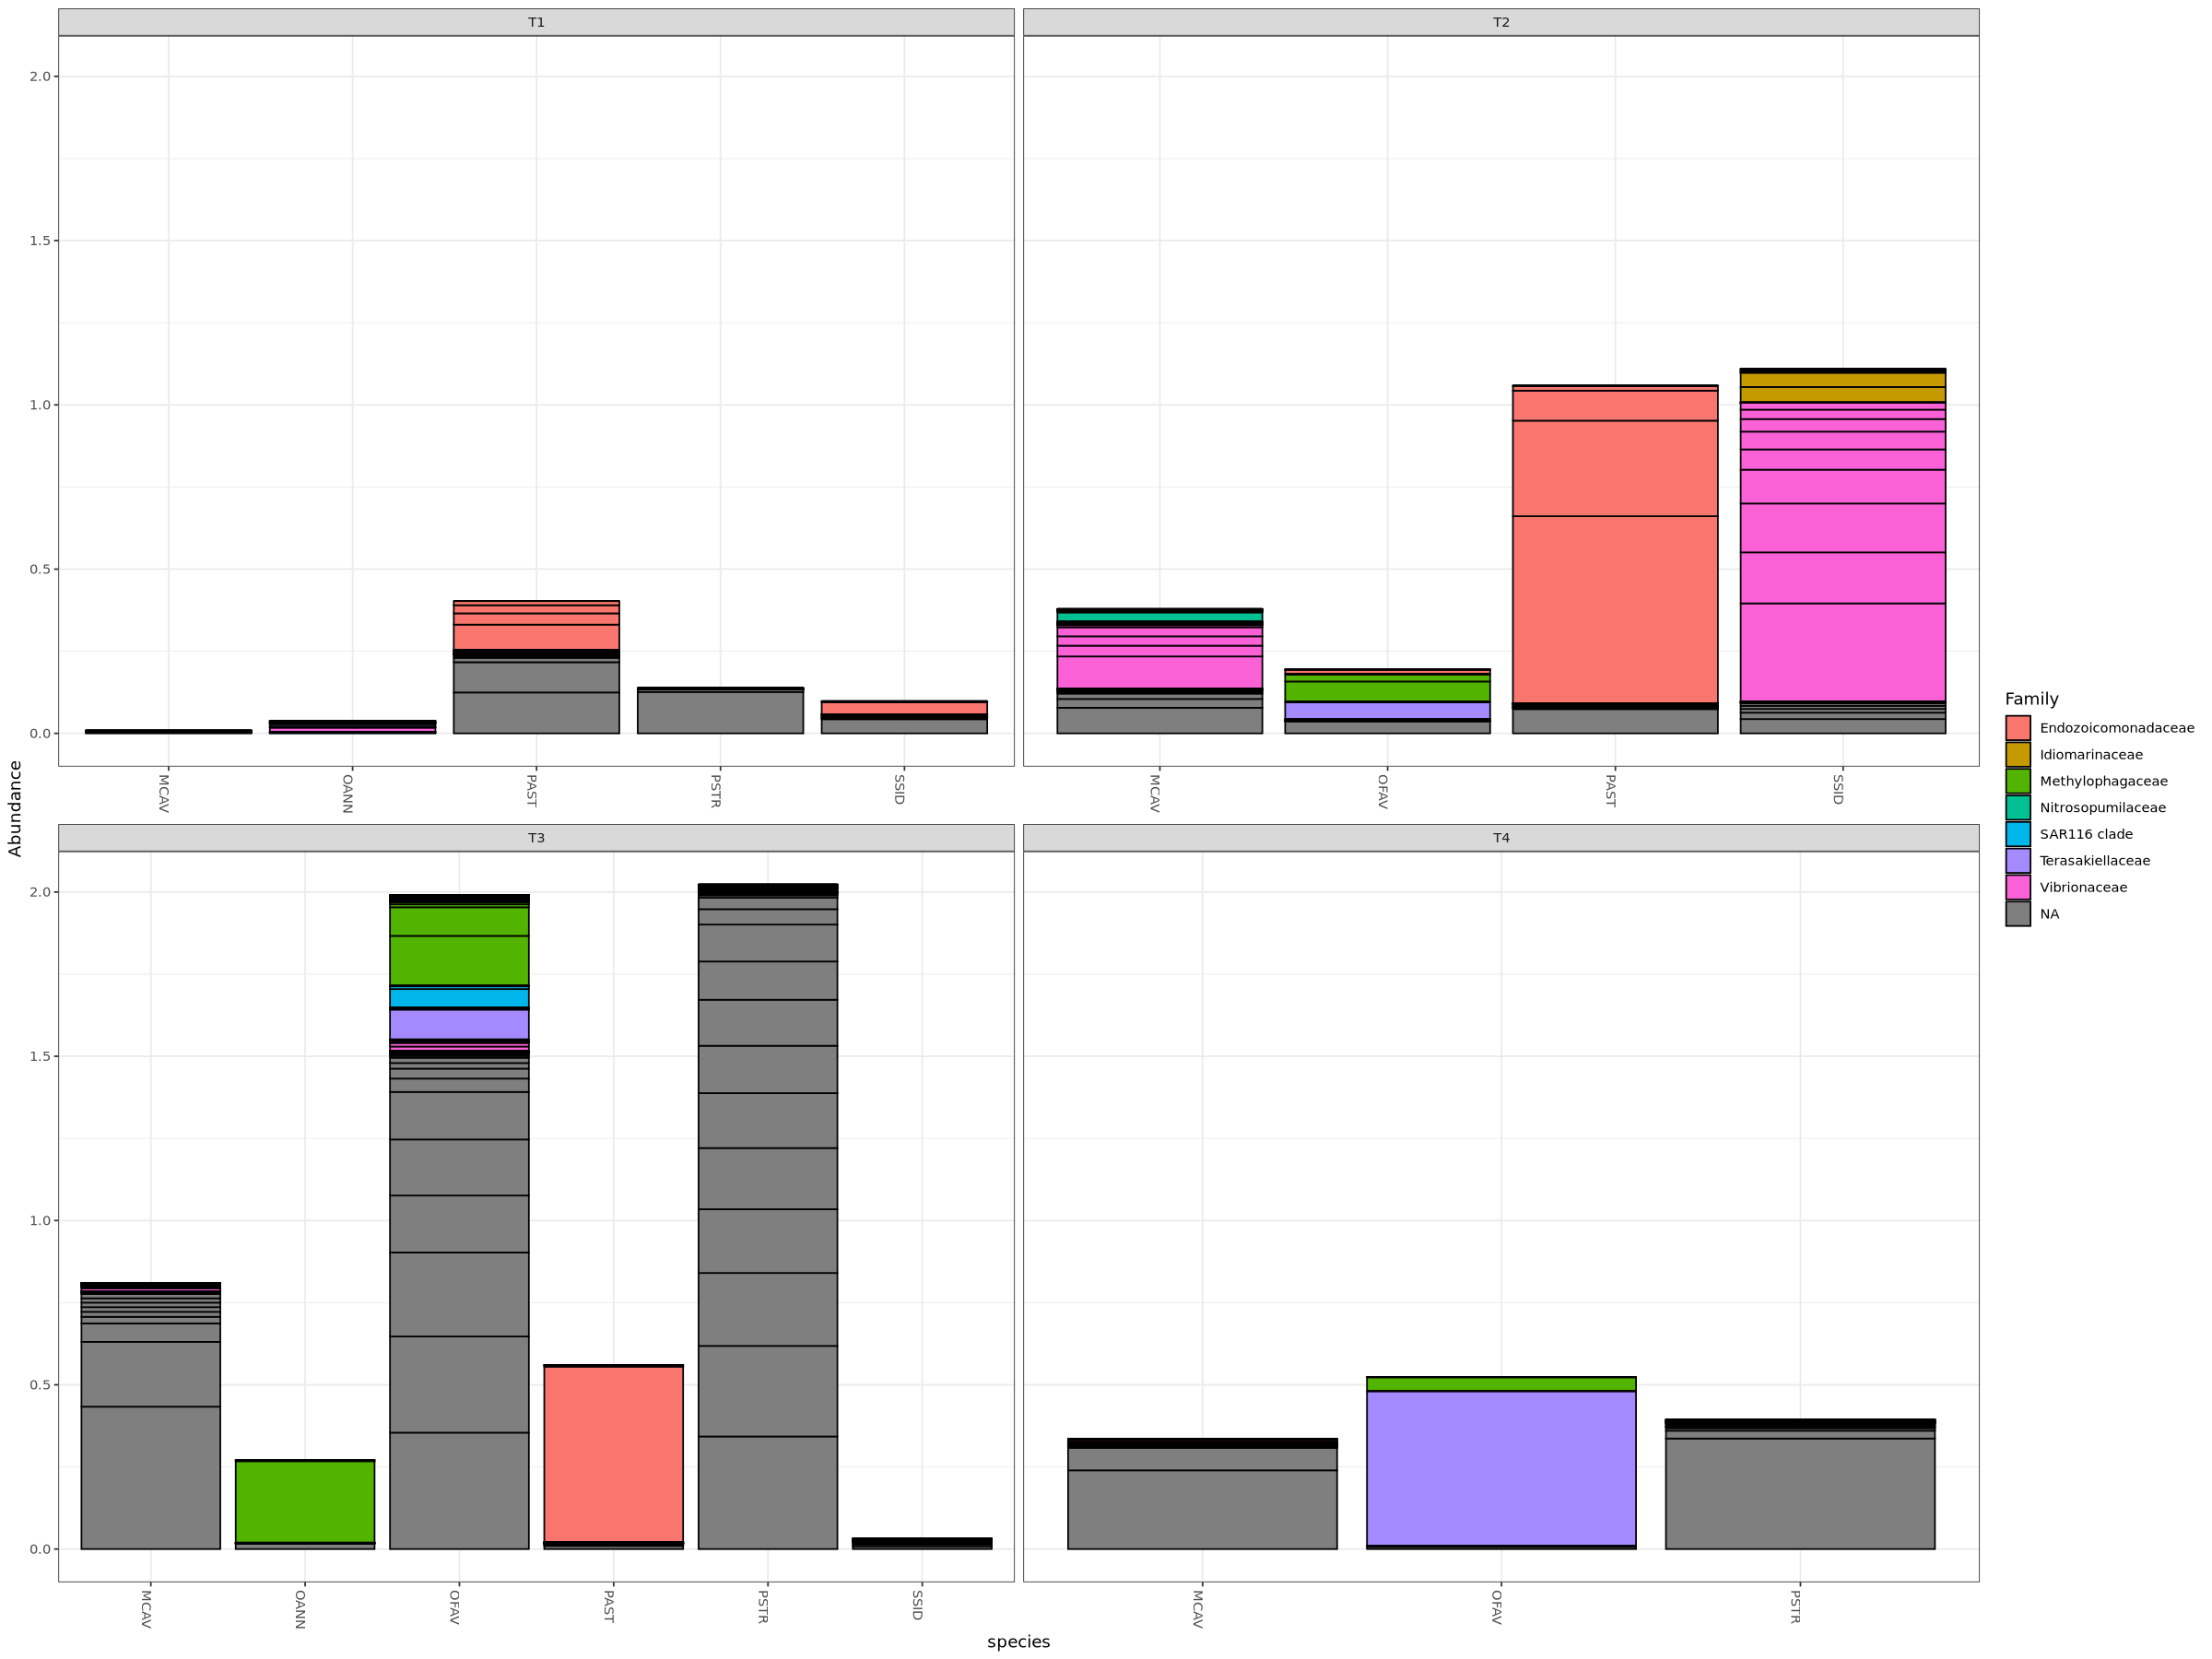

In [80]:
top20 <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20] 
ps.top20 <- transform_sample_counts(ps, function(OTU) OTU/sum(OTU)) 
ps.top20 <- prune_taxa(top20, ps.top20) 
plot_bar(ps.top20, x="species", fill="Family") + facet_wrap(~transect, scales="free_x")

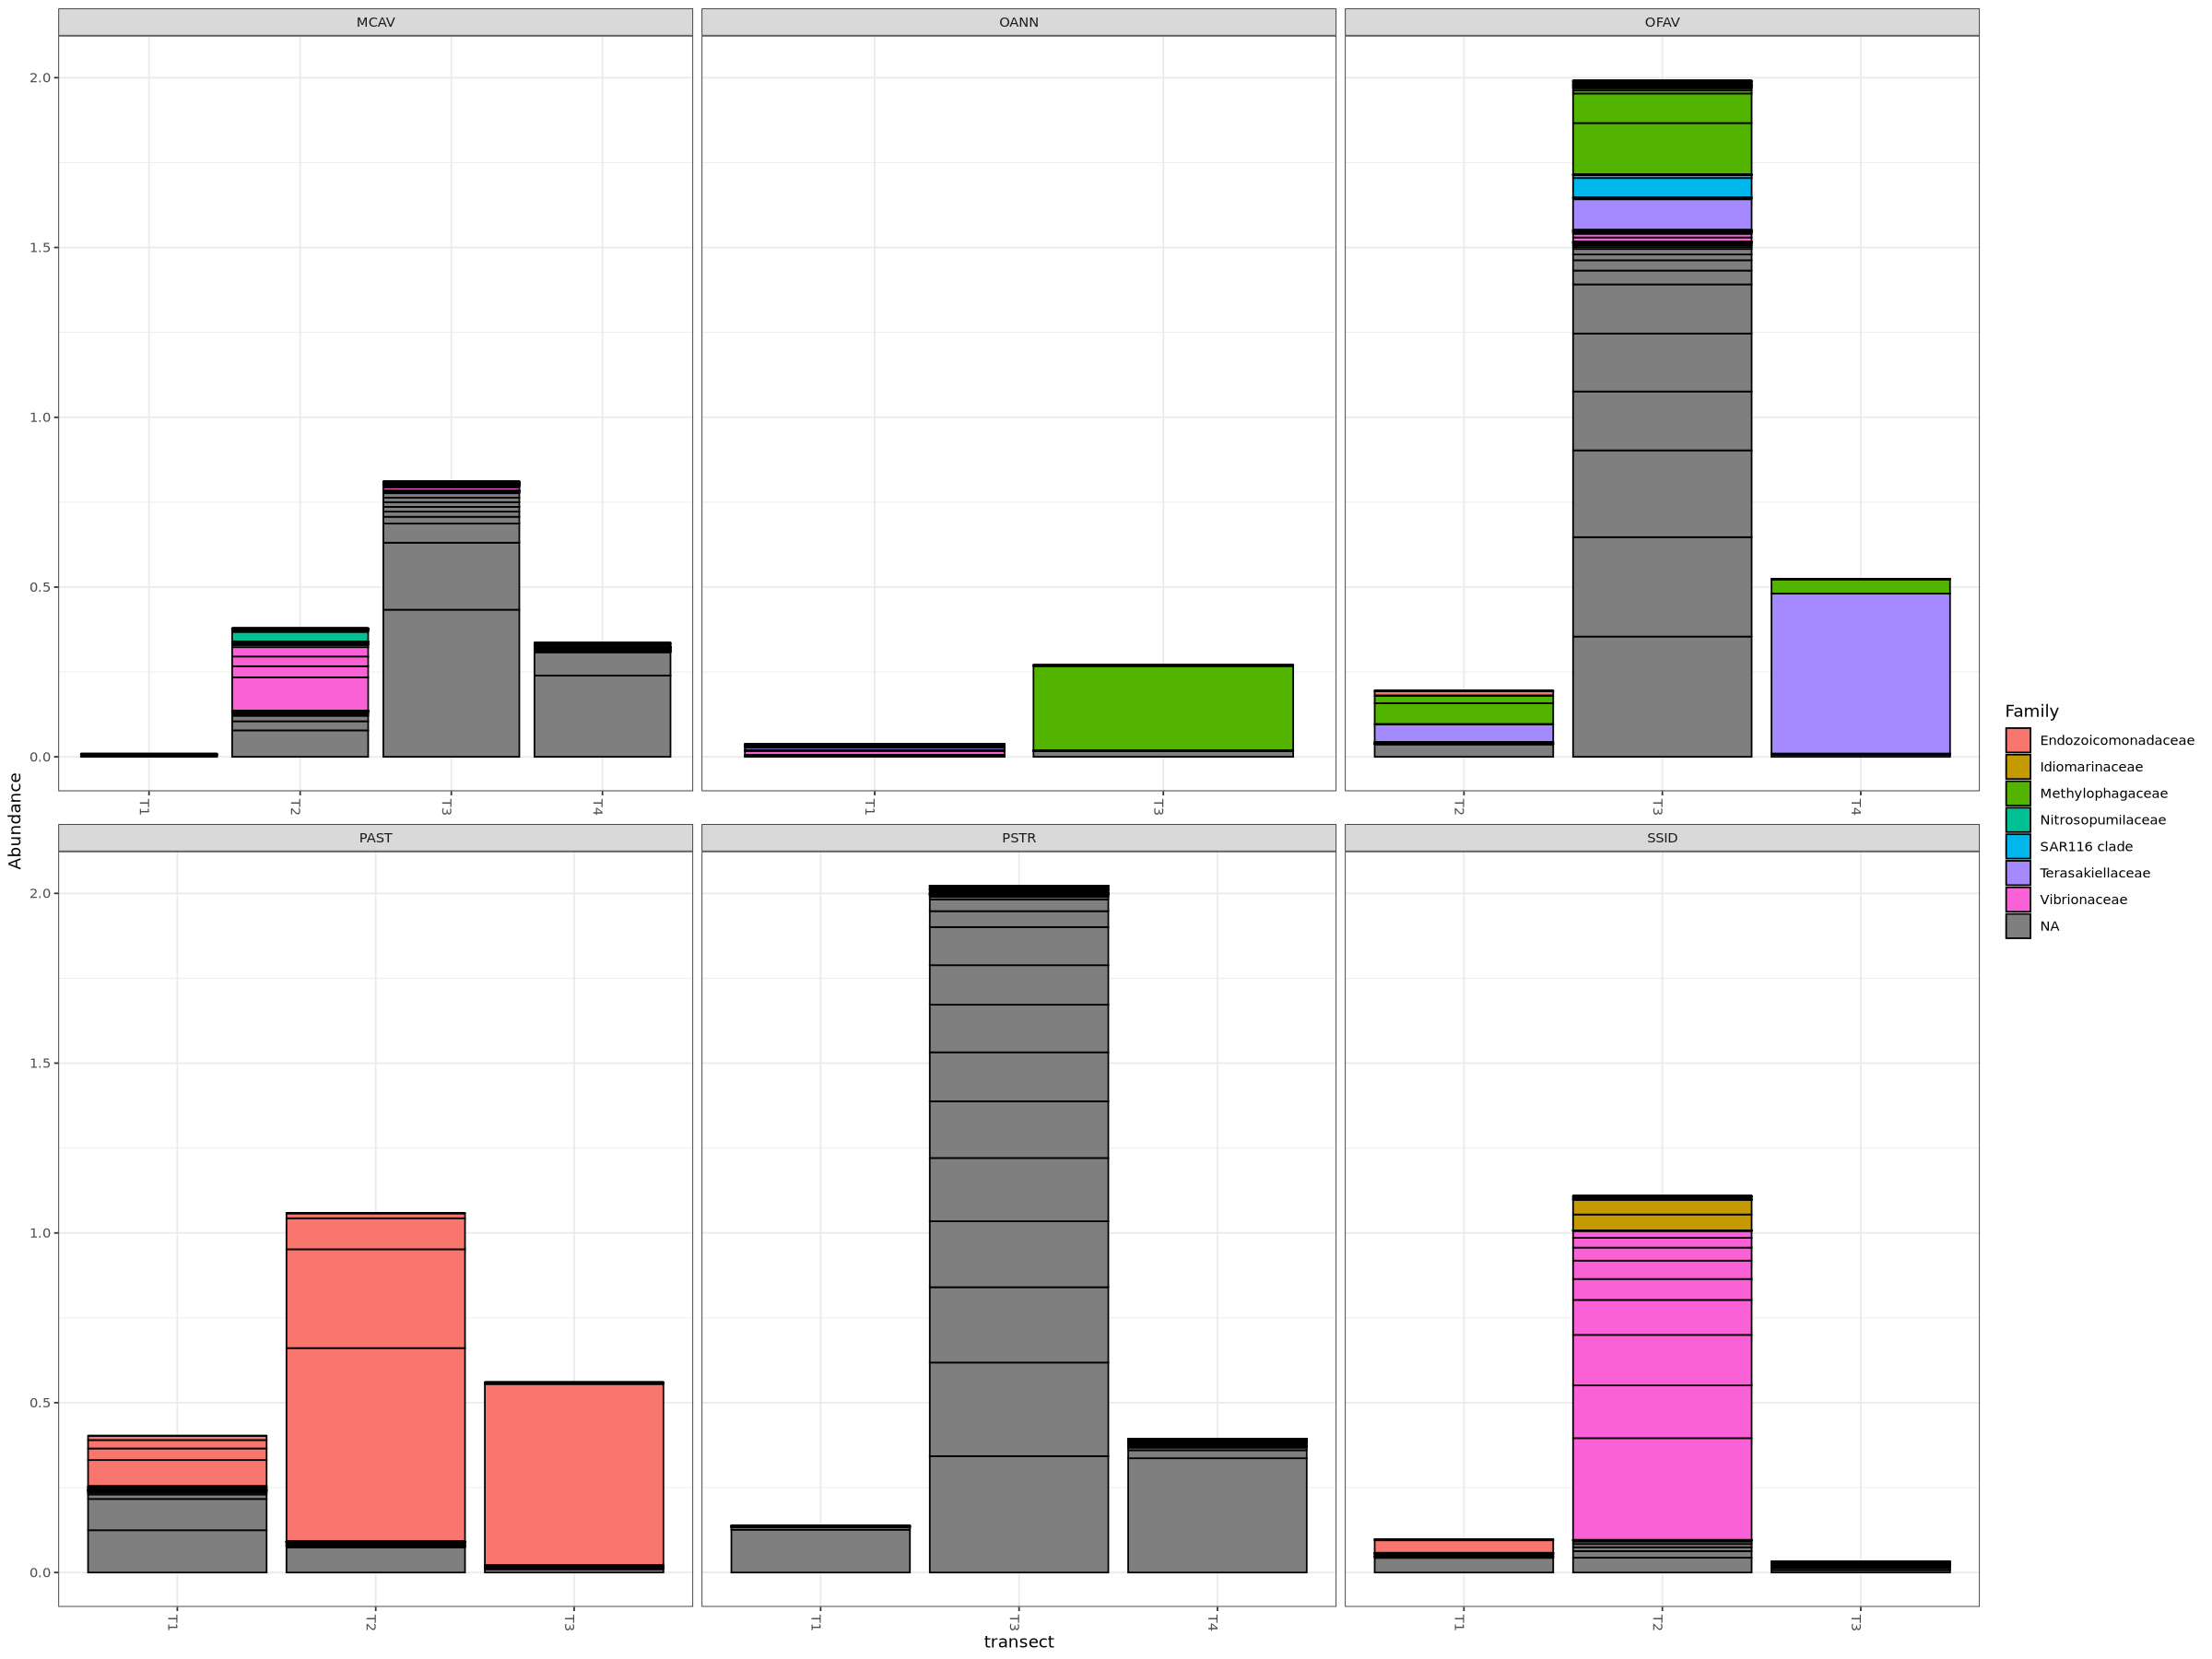

In [81]:
top20 <- names(sort(taxa_sums(ps), decreasing=TRUE))[1:20] 
ps.top20 <- transform_sample_counts(ps, function(OTU) OTU/sum(OTU)) 
ps.top20 <- prune_taxa(top20, ps.top20) 
plot_bar(ps.top20, x="transect", fill="Family") + facet_wrap(~species, scales="free_x")